In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pymc3 as pm

import pystan

%matplotlib inline

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train/255
x_test  = x_test/255

def subset(label, data=x_train, labels=y_train):
    '''
    e.g. subset(3) -> gets all pictures of digit 3
    '''
    assert label >= 0 and label <= 9
    
    return data[np.argwhere(labels == 3)]

In [4]:
def plot(image, figsize=(16, 7)):
    
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='Greys')
    

def plot_many():
    pass

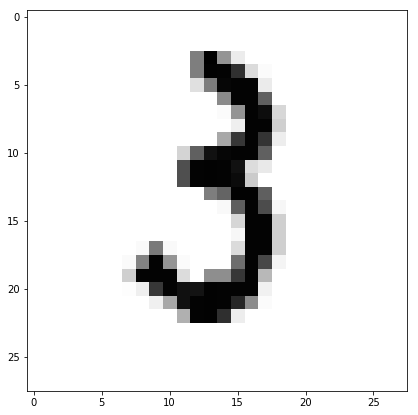

In [5]:
plot(x_train[1234])

### Standard CNN 

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train.reshape(-1, 28, 28, 1), 
          y=y_train, epochs=10)

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/10
60000/60000 [==============================] - 116s 2ms/step - loss: 0.2181 - acc: 0.9353
Epoch 2/10
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0894 - acc: 0.9723
Epoch 3/10
60000/60000 [==============================] - 112s 2ms/step - loss: 0.0621 - acc: 0.9804
Epoch 4/10
60000/60000 [==============================] - 116s 2ms/step - loss: 0.0461 - acc: 0.9850
Epoch 5/10
47264/60000 [======================>.......] - ETA: 24s - loss: 0.0358 - acc: 0.9883

KeyboardInterrupt: 

In [6]:
tf.keras.utils.to_categorical(y_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)